# 03. Data Preprocessing

In [8]:
import sys
print(sys.executable)

c:\Users\Admin\miniconda3\envs\timeseries\python.exe


## Objective
- Clean the dataset
- Prepare the data for feature engineering

## 1. Setup and Load Dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Add project root to path
import os
import sys
sys.path.append(os.path.abspath('../'))
from src.data_loader import load_raw_data

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print(f"✓ Python version: {sys.version.split()[0]}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ Python version: 3.10.19
✓ Pandas version: 2.2.2
✓ NumPy version: 1.26.4


In [2]:
# Load raw data using custom loader
try:
    df = load_raw_data()
    print(f"✓ Data loaded successfully")
    print(f"  Shape: {df.shape}")
    print(f"  Period: {df.index.min()} to {df.index.max()}")
    print(f"  Frequency: {df.index.freq if df.index.freq else 'Not set (likely 15min)'}")
except Exception as e:
    print(f"❌ Error: {e}")

👉 Loading: C:\dataset\Electricity-Load-Diagrams\data\raw\electricity_data.parquet
✅ Data loaded successfully!
📊 Samples: 140256
👥 Number of customers: 370
🕒 Time span: 2011-01-01 00:15:00 → 2015-01-01 00:00:00
✓ Data loaded successfully
  Shape: (140256, 370)
  Period: 2011-01-01 00:15:00 to 2015-01-01 00:00:00
  Frequency: Not set (likely 15min)


## 2. Missing Value Handling
- The dataset contains no missing values. Therefore, forward fill or interpolation is not required.
- Even though there are no missing values, duplicates still needed to verified.

In [3]:
# Check duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates if any
df = df.drop_duplicates()

Number of duplicate rows: 0


## 3. Outlier Analysis

In [4]:
# Z-score method
z_scores = (df - df.mean()) / df.std()
outliers = (np.abs(z_scores) > 3)

print("Number of detected outliers:")
print(outliers.sum().sum())

Number of detected outliers:
169423


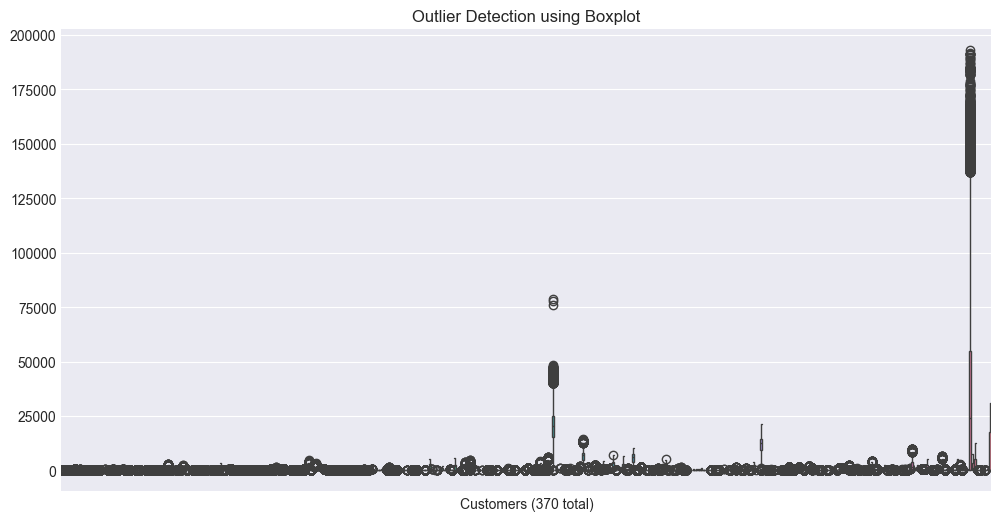

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Outlier Detection using Boxplot")
plt.xticks([]) # turn off customer labels
plt.xlabel("Customers (370 total)")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_15868\1321639457.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_outliers.values, y=top_outliers.index, palette='viridis')


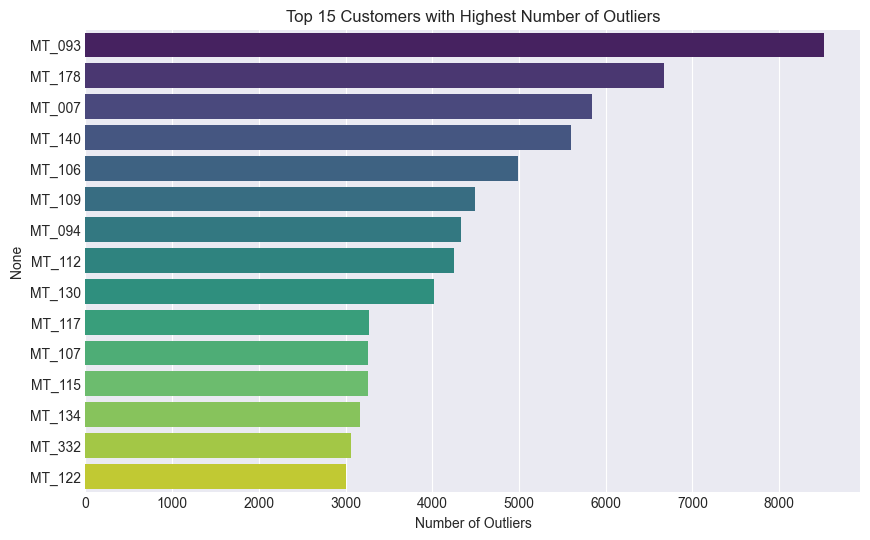

In [ ]:
# Number of outlier for each customer
outlier_counts = (np.abs(z_scores) > 3).sum()

# Top 15 customer with the most outliers
top_outliers = outlier_counts.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_outliers.values, y=top_outliers.index, palette='viridis')
plt.title('Top 15 Customers with Highest Number of Outliers')
plt.xlabel('Number of Outliers')
plt.show()

Zero-Value:  Structural Zeros and True Zeros

In [13]:
total_cells = df.size
total_zeros = (df == 0).sum().sum()
zero_percentage = (total_zeros / total_cells) * 100

print(f"Total Data Points: {total_cells:,}")
print(f"Total Zero Values: {total_zeros:,}")
print(f"Percentage of Zeros: {zero_percentage:.2f}%")

Total Data Points: 51,894,720
Total Zero Values: 10,457,342
Percentage of Zeros: 20.15%


--- STARTING ZERO VALUE ANALYSIS ---
Total Data Points: 51,894,720
Total Zero Values: 10,457,342
Percentage of Zeros: 20.15% (Matches report ~20.15%)


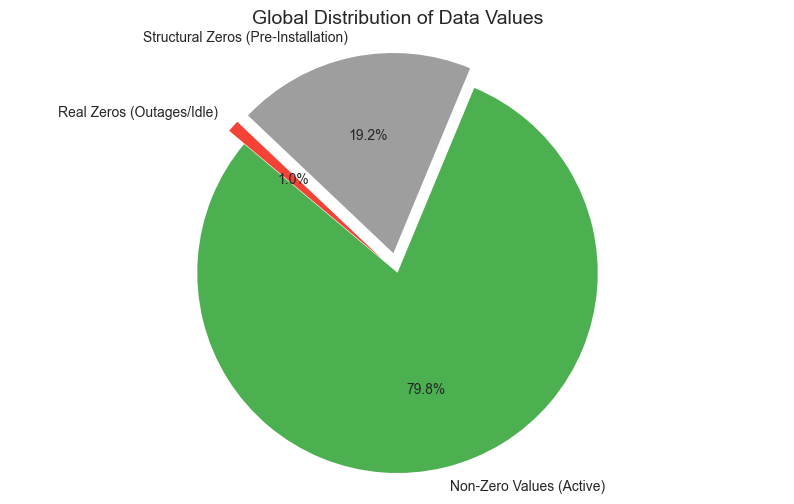

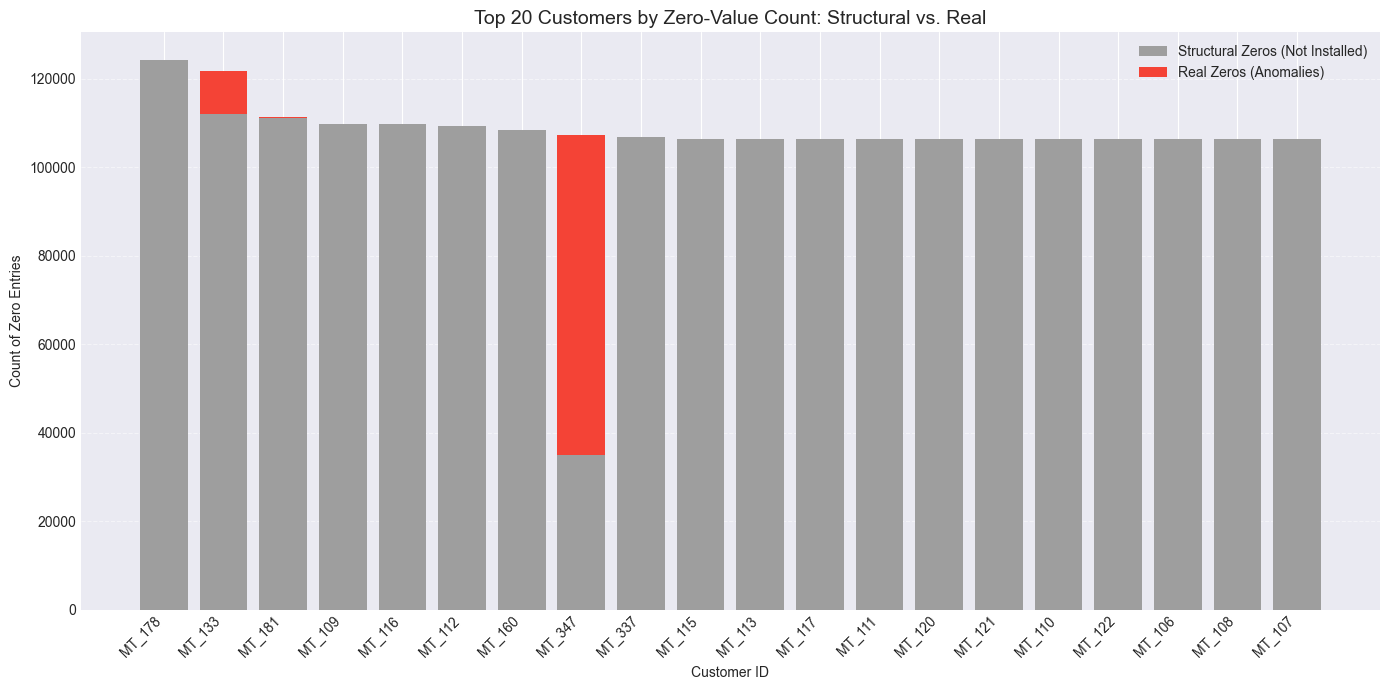

In [15]:
def analyze_zero_values_english(df):
    print("--- STARTING ZERO VALUE ANALYSIS ---")
    
    # 1. Global Statistics
    total_cells = df.size
    total_zeros = (df == 0).sum().sum()
    zero_percentage = (total_zeros / total_cells) * 100
    
    print(f"Total Data Points: {total_cells:,}")
    print(f"Total Zero Values: {total_zeros:,}")
    print(f"Percentage of Zeros: {zero_percentage:.2f}% (Matches report ~20.15%)")
    
    # 2. Classification: Structural (Pre-meter) vs. Real (Outages/Idle)
    structural_zeros = 0
    real_zeros = 0
    
    customer_stats = []

    for col in df.columns:
        series = df[col]
        
        # logic: If cumulative sum is 0, it means we haven't seen any usage yet.
        is_structural = (series.cumsum() == 0)
        
        n_structural = is_structural.sum()
        
        # Real zeros are 0 values occurring AFTER the first non-zero value
        n_real = ((series == 0) & (~is_structural)).sum()
        
        structural_zeros += n_structural
        real_zeros += n_real
        
        customer_stats.append({
            'Customer': col,
            'Structural_Zeros': n_structural,
            'Real_Zeros': n_real,
            'Total_Rows': len(series)
        })

    # Create DataFrame for visualization
    zero_df = pd.DataFrame(customer_stats)
    zero_df['Total_Zeros'] = zero_df['Structural_Zeros'] + zero_df['Real_Zeros']

    # --- VISUALIZATION 1: Global Distribution (Pie Chart) ---
    non_zeros = total_cells - total_zeros
    labels = ['Non-Zero Values (Active)', 'Structural Zeros (Pre-Installation)', 'Real Zeros (Outages/Idle)']
    sizes = [non_zeros, structural_zeros, real_zeros]
    colors = ['#4CAF50', '#9E9E9E', '#F44336'] # Green, Gray, Red
    explode = (0, 0.1, 0.1)  

    plt.figure(figsize=(10, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Global Distribution of Data Values', fontsize=14)
    plt.axis('equal') 
    plt.show()

    # --- VISUALIZATION 2: Top 20 Customers with Zeros (Stacked Bar) ---
    top_zeros = zero_df.sort_values('Total_Zeros', ascending=False).head(20)

    plt.figure(figsize=(14, 7))
    
    # Bar 1: Structural (Gray)
    plt.bar(top_zeros['Customer'], top_zeros['Structural_Zeros'], label='Structural Zeros (Not Installed)', color='#9E9E9E')
    
    # Bar 2: Real (Red) - Stacked on top
    plt.bar(top_zeros['Customer'], top_zeros['Real_Zeros'], bottom=top_zeros['Structural_Zeros'], label='Real Zeros (Anomalies)', color='#F44336')

    plt.title('Top 20 Customers by Zero-Value Count: Structural vs. Real', fontsize=14)
    plt.ylabel('Count of Zero Entries')
    plt.xlabel('Customer ID')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return zero_df

stats = analyze_zero_values_english(df)
# Run the function
# stats = analyze_zero_values_english(df)

## 4. Time Index Processing

In [12]:
# Try setting 15-minute frequency
df = df.asfreq("15T")

print("Frequency after setting:", df.index.freq)

Frequency after setting: <15 * Minutes>


## 5. Scaling (If Needed)
- Standardization / Normalization
- Lý do lựa chọn

## 6. Train-Test Split Strategy
- Time-based split
- Tránh data leakage


## 7. Conclusion
- Dữ liệu sẵn sàng cho feature engineering